## Time Series Template

For Phase 1 of this project I want to chart data over the course of the 5-year ACS. The first 5-year ACS was published in 2010, and you are not supposed to compare years that overlap. This leaves us with 3 datasets: 2000, 2015, 2020.

This notebook attempts to create and graph a time series of a simple table: [B05012: Nativity in the United States](https://data.census.gov/table/ACSDT5Y2020.B05012?g=9700000US3612510) in such a way that it can be reused for other variables. I call this table "simple" because it only counts 3 values: "Total", "Native" and "Foreign-Born".

### Tables, Groups and Variables

The ACS uses the word "Table" to describe the data structure that holds information for a specific concept. `censusdis` (the Python package I am using to get data from the Census API) calls this data structure a `group`. Here is how we can use `censusdis` to get the exact same data in Python that you saw in the link above:

In [1]:
import censusdis.data as ced

from censusdis.datasets import ACS5
from censusdis.states import NY

df = ced.download(
    dataset=ACS5,
    vintage=2020,
    group="B05012",
    state=NY,
    school_district_unified="12510",
)
df

,STATE,SCHOOL_DISTRICT_UNIFIED,B05012_001E,B05012_002E,B05012_003E,GEO_ID,NAME
0,36,12510,46046,31638,14408,9700000US3612510,"Great Neck Union Free School District, New York"


The principal difference between the two is the structure of the data. The data on the website is "long": the first column is called "Label" and has a description of the values. The next column is called "Estimate" and contains the numbers we care about.

In `censusdis` the data is "wide". There is only one row, and the the column names are variables (ex. `B05012_001E`) that do not clearly correspond to what they measure.

We can use the function `ced.variables.group_tree` to get the Label that corresponds to all the variables in a given group:

In [2]:
ced.variables.group_tree(ACS5, 2020, "B05012")["Estimate"]

+ Total: (B05012_001E)
    + Native (B05012_002E)
    + Foreign-Born (B05012_003E)

And we can use the function `name_mapper` to change the columns of the df so that the variables becomes labels:

In [3]:
from utils import name_mapper

# Note that both a `group` and `vintage` are required here
df.rename(columns=name_mapper(group="B05012", vintage=2020))

,STATE,SCHOOL_DISTRICT_UNIFIED,Total,Native,Foreign-Born,GEO_ID,NAME
0,36,12510,46046,31638,14408,9700000US3612510,"Great Neck Union Free School District, New York"


### Label Changes Over Time

One issue to keep in mind is that the ACS is not designed as a time series. For example, variables are allowed to change meaning over time. I first ran into this issue when doing an analysis of people who work from home. The variable which counts that is `B08006_017E` - except in 2005, when it was used to count the number of people who commute by motorcycle! You can learn more about this issue [here](https://github.com/censusdis/censusdis/blob/main/notebooks/Variable%20Search.ipynb).

Before we compare values over time we need to confirm that the variable has been used for the same thing over the period we care about. In my [last](https://arilamstein.com/covid-demographics-explorer/) Census-related project I created a function (`get_unique_labels_for_variable`) which makes this easy. The output of this function is a dictionary where the keys are labels, and the values are the years that used that label. Sometimes labels change in minor ways (ex. "Total" becomes "Total:"), and sometimes they are used to measure something completely different.

Here is code to run that function over the 3 years we're interested in, for the 3 variables that are in group `B05012`:


In [4]:
from utils import get_unique_labels_for_variable

print(get_unique_labels_for_variable(ACS5, "B05012_001E", [2010, 2015, 2020]))
print(get_unique_labels_for_variable(ACS5, "B05012_002E", [2010, 2015, 2020]))
print(get_unique_labels_for_variable(ACS5, "B05012_003E", [2010, 2015, 2020]))

defaultdict(<class 'list'>, {'Estimate!!Total': [2010, 2015], 'Estimate!!Total:': [2020]})
defaultdict(<class 'list'>, {'Estimate!!Total!!Native': [2010, 2015], 'Estimate!!Total:!!Native': [2020]})
defaultdict(<class 'list'>, {'Estimate!!Total!!Foreign-Born': [2010, 2015], 'Estimate!!Total:!!Foreign-Born': [2020]})


As you can see, the only difference in the labels is that in 2020 they added a ":" to the word "Total". This means that we can compare these values and be confident that they are measuring the same thing.

### Generating a Time Series 

The code below gets the values for `B05012` over the three years we're interested in and combines them into a single dataframe. It also changes the column names to be labels so that they are easier to read.

In [5]:
import pandas as pd

YEARS = [2010, 2015, 2020]
GROUP = "B05012"
df = None

for year in YEARS:
    # This loop can take a while, so provide feedback to the user
    print(".", end="", flush=True)

    df_new = ced.download(
        dataset=ACS5,
        vintage=year,
        group=GROUP,
        state=NY,
        school_district_unified="12510",
    )

    df_new["Year"] = year

    if df is None:
        df = df_new
    else:
        df = pd.concat([df_new, df])

# Again: This rename is dangerous unless you first verify that the variable
# has a consistent meaning over time!
df = df.rename(columns=name_mapper(group=GROUP, vintage=2020))
df = df.sort_values(by="Year")
df = df[["Total", "Native", "Foreign-Born", "Year"]]  # Drop unnecessary columns
df

...

,Total,Native,Foreign-Born,Year
0,43899,30699,13200,2010
0,44975,29935,15040,2015
0,46046,31638,14408,2020


### Graphing the data

The most obvious way to view this data is as a line graph. This will allow us to see how the numbers change over time. There are many charting libraries in Python, and I've heard good things about Plotly for a while, so I thought to try using it here.

Note that this code is written in such a way that it would be easy to turn it into a function. For example, it iterates over a list of columns to add lines to the graph.

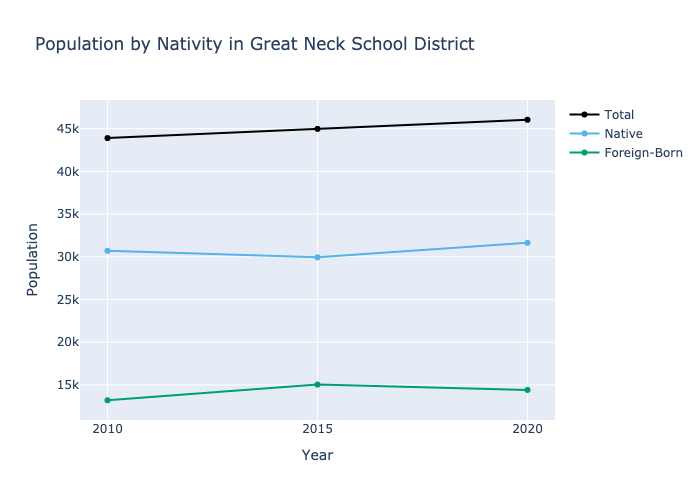

In [6]:
import plotly.graph_objects as go
import plotly.io as pio

# By default plotly graphs are interactive. While this is great locally, they do not render 
# on github. This fixes that. See https://github.com/plotly/plotly.py/issues/931#issuecomment-2098209279
pio.renderers.default = "vscode+png"

colorblind_palette = [
    "#E69F00",
    "#56B4E9",
    "#009E73",
    "#F0E442",
    "#0072B2",
    "#D55E00",
    "#CC79A7",
]

fig = go.Figure()

x_cols = ["Total", "Native", "Foreign-Born"]
y_col = "Year"
for idx, x_col in enumerate(x_cols):
    color = "black" if x_col == "Total" else colorblind_palette[idx]
    fig.add_trace(
        go.Scatter(
            x=df[y_col],
            y=df[x_col],
            mode="lines+markers",
            name=x_col,
            line=dict(color=color),
            hovertemplate="Year: %{x}<br>" + x_col + ": %{y:,}<extra></extra>",
        )
    )

# Update layout
fig.update_layout(
    title="Population by Nativity in Great Neck School District",
    xaxis_title="Year",
    yaxis_title="Population",
    xaxis=dict(
        tickmode="array",
        tickvals=df["Year"],
        ticktext=[str(year) for year in df["Year"]],
    ),
)

fig.show()

### Graphing Percent Change

The above graph shows a consistent increase in total population, but fluctuations in the underlying segments. The fluctuations appear small, but that might be because the y-axis covers the total population. If we convert the data to show percent change from the previous reporting period, we can get a feel for how significant those fluctuations are.

In [7]:
print(df)

df_pct_change = df.pct_change()
df_pct_change = df_pct_change * 100
df_pct_change["Year"] = [2010, 2015, 2020]  # Don't want a % change of this column!
df_pct_change = df_pct_change.fillna(0)
df_pct_change

   Total  Native  Foreign-Born  Year
0  43899   30699         13200  2010
0  44975   29935         15040  2015
0  46046   31638         14408  2020


,Total,Native,Foreign-Born,Year
0,0.000000,0.000000,0.000000,2010
0,2.451081,-2.488680,13.939394,2015
0,2.381323,5.688993,-4.202128,2020


Now we can graph that data using very similar code as before:

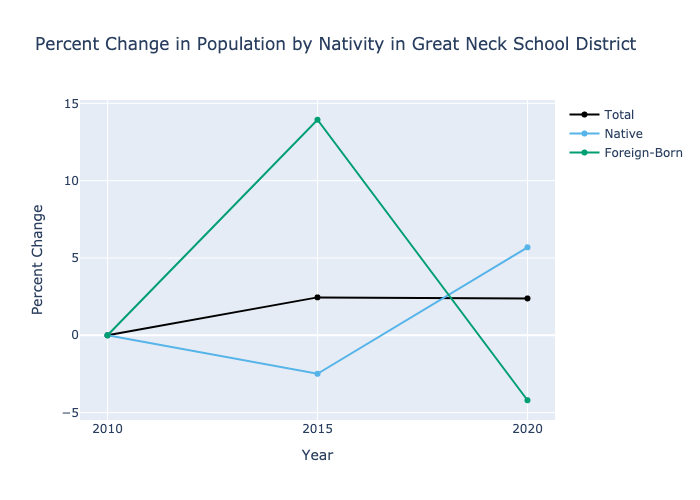

In [8]:
import plotly.graph_objects as go

colorblind_palette = [
    "#E69F00",
    "#56B4E9",
    "#009E73",
    "#F0E442",
    "#0072B2",
    "#D55E00",
    "#CC79A7",
]

fig = go.Figure()

x_cols = ["Total", "Native", "Foreign-Born"]
y_col = "Year"
for idx, x_col in enumerate(x_cols):
    color = "black" if x_col == "Total" else colorblind_palette[idx]
    fig.add_trace(
        go.Scatter(
            x=df_pct_change[y_col],
            y=df_pct_change[x_col],
            mode="lines+markers",
            name=x_col,
            line=dict(color=color),
            hovertemplate="Year: %{x}<br>" + x_col + ": %{y:,}<extra></extra>",
        )
    )

# Update layout
fig.update_layout(
    title="Percent Change in Population by Nativity in Great Neck School District",
    xaxis_title="Year",
    yaxis_title="Percent Change",
    xaxis=dict(
        tickmode="array",
        tickvals=df_pct_change["Year"],
        ticktext=[str(year) for year in df_pct_change["Year"]],
    ),
)

fig.show()

### Graphing Percent Foreign-Born

Because this data is binary (every person is either Native or Foreign-Born), it might be insightful to calculate the ratio between the two numbers:

In [9]:
print(df)

df["Percent Foreign-Born"] = (df["Foreign-Born"] / df["Total"] * 100).round(1)

df

   Total  Native  Foreign-Born  Year
0  43899   30699         13200  2010
0  44975   29935         15040  2015
0  46046   31638         14408  2020


,Total,Native,Foreign-Born,Year,Percent Foreign-Born
0,43899,30699,13200,2010,30.1
0,44975,29935,15040,2015,33.4
0,46046,31638,14408,2020,31.3


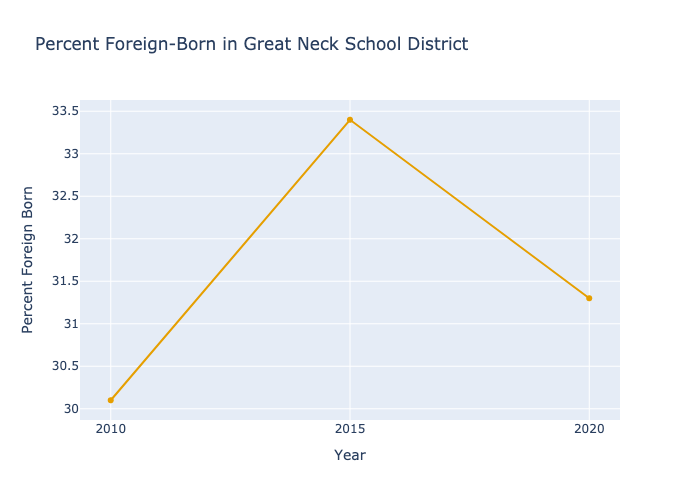

In [10]:
import plotly.graph_objects as go

colorblind_palette = [
    "#E69F00",
    "#56B4E9",
    "#009E73",
    "#F0E442",
    "#0072B2",
    "#D55E00",
    "#CC79A7",
]

fig = go.Figure()

x_cols = ["Percent Foreign-Born"]
y_col = "Year"
for idx, x_col in enumerate(x_cols):
    color = "black" if x_col == "Total" else colorblind_palette[idx]
    fig.add_trace(
        go.Scatter(
            x=df[y_col],
            y=df[x_col],
            mode="lines+markers",
            name=x_col,
            line=dict(color=color),
            hovertemplate="Year: %{x}<br>" + x_col + ": %{y:,}<extra></extra>",
        )
    )

# Update layout
fig.update_layout(
    title="Percent Foreign-Born in Great Neck School District",
    xaxis_title="Year",
    yaxis_title="Percent Foreign Born",
    xaxis=dict(
        tickmode="array",
        tickvals=df["Year"],
        ticktext=[str(year) for year in df["Year"]],
    ),
)

fig.show()